In [33]:
#import libraries
import os
from pandas import read_csv
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

%matplotlib inline

import pandas_profiling


from scipy.stats import skew, norm
from scipy import stats
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn import linear_model
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, classification_report, accuracy_score
from math import sqrt



from lightgbm import LGBMRegressor
import lightgbm as lgb

In [34]:
#import data
current_path = os.getcwd()
current_path = os.path.dirname(current_path)
print(current_path)
#C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone\data_mart
dataset = current_path + '//data_mart//reporting_wr.csv'
print(dataset)
dataset = pd.read_csv(dataset, index_col = 0)
dataset.head()

#https://stackoverflow.com/questions/9856683/using-pythons-os-path-how-do-i-go-up-one-director

C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone
C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone//data_mart//reporting_wr.csv


,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,receiving_rec_yards_zscore,receiving_receptions_zscore,receiving_rush_att_zscore,receiving_rush_td_zscore,receiving_rush_yds_zscore,receiving_scrim_plays_zscore,receiving_scrim_tds_zscore,receiving_scrim_yds_zscore,receiving_seasons_zscore,max_madden_zscore
fms_id,,,,,,,,,,,,,,,,,,,,,
2,4047646.0,A.J. Brown,A.J.,Brown,WR,WR,O,Ole Miss,2019,NaN,...,1.020082,0.745111,-0.597165,-0.440830,-0.564573,0.523967,0.277925,0.911099,-0.273056,-0.145738
216,3914328.0,Andy Isabella,Andy,Isabella,WR,WR,O,UMass,2019,NaN,...,1.596537,1.364694,1.560318,1.048808,2.030272,1.613414,1.681258,1.821476,0.634520,-0.145738
248,4049301.0,Anthony Johnson,Anthony,Johnson,WR,WR,O,Buffalo,2019,NaN,...,0.363859,-0.080999,-0.381417,-0.440830,-0.602509,-0.166902,0.925617,0.270539,-1.180632,-0.896762
275,4043161.0,Antoine Wesley,Antoine,Wesley,WR,WR,O,Texas Tech,2019,NaN,...,-0.508269,-0.597318,-0.543228,-0.440830,-0.579748,-0.671767,-0.801563,-0.570839,-0.273056,NaN
434,3917067.0,Bisi Johnson,Bisi,Johnson,WR,WR,O,Colorado State,2019,NaN,...,-0.006263,-0.199015,-0.543228,-0.440830,-0.465939,-0.313047,-0.585665,-0.069308,0.634520,NaN


In [35]:
#determine which columns have None values
none_columns = []
for x in dataset.columns:
    if dataset[x].isnull().values.any() == True:
        none_columns.append(x)
print(none_columns)

['espn_id', 'selection_number', 'position_rank', 'position_group_rank', 'section_rank', 'drafting_team', 'home_city', 'home_state', 'home_country', 'forty', 'vertical', 'bench', 'broad', 'threecone', 'shuttle', 'max_madden', 'forty_zscore', 'vertical_zscore', 'bench_zscore', 'broad_zscore', 'threecone_zscore', 'shuttle_zscore', 'max_madden_zscore']


In [36]:
def z_score_rescale(data_mean, data_std, z_score):
    X = (z_score* data_std) + data_mean
    return X

In [37]:
dataset['max_madden'].describe()

count    466.000000
mean      73.358369
std        9.330624
min       52.000000
25%       66.000000
50%       72.000000
75%       79.000000
max       99.000000
Name: max_madden, dtype: float64

In [38]:
#Deal with None Values
none_dict = {'espn_id': 0,    
    'selection_number': 400,
    'position_rank': 400,
    'position_group_rank': 400,
    'section_rank': 400,
    'drafting_team': 'No Team',
    'home_city': 'No City',
    'home_state': 'No State',
    'home_country': 'USA',
    'forty': 0,
    'vertical': 0, 
    'bench': 0, 
    'broad': 0,
    'threecone': 0,
    'shuttle': 0,
    'max_madden': dataset['max_madden'].min() - 10,
    'forty_zscore': dataset['forty_zscore'].mean(), 
    'vertical_zscore': dataset['vertical_zscore'].mean(), 
    'bench_zscore': dataset['bench_zscore'].mean(), 
    'broad_zscore': dataset['broad_zscore'].mean(), 
    'threecone_zscore': dataset['threecone_zscore'].mean(), 
    'shuttle_zscore': dataset['shuttle_zscore'].mean(), 
    'max_madden_zscore': dataset['max_madden_zscore'].min() - 0.1}
    #'football_spending_zscore': dataset['football_spending_zscore'].min(), 
    #'coaches_salaries_zscore':  dataset['coaches_salaries_zscore'].min(), 
    #'ticket_sales_zscore':  dataset['ticket_sales_zscore'].min()}

print(none_dict)

for none_col in none_columns:
    dataset[none_col] = dataset[none_col].fillna(none_dict[none_col])
   

#https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

{'espn_id': 0, 'selection_number': 400, 'position_rank': 400, 'position_group_rank': 400, 'section_rank': 400, 'drafting_team': 'No Team', 'home_city': 'No City', 'home_state': 'No State', 'home_country': 'USA', 'forty': 0, 'vertical': 0, 'bench': 0, 'broad': 0, 'threecone': 0, 'shuttle': 0, 'max_madden': 42.0, 'forty_zscore': -3.7739118621057414e-15, 'vertical_zscore': 1.0559149014391581e-15, 'bench_zscore': -1.8079967831045805e-16, 'broad_zscore': -9.376001123702435e-16, 'threecone_zscore': 3.622648987438306e-15, 'shuttle_zscore': -1.354387015481417e-15, 'max_madden_zscore': -2.3915212250992455}


In [39]:
dataset.head()

,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,receiving_rec_yards_zscore,receiving_receptions_zscore,receiving_rush_att_zscore,receiving_rush_td_zscore,receiving_rush_yds_zscore,receiving_scrim_plays_zscore,receiving_scrim_tds_zscore,receiving_scrim_yds_zscore,receiving_seasons_zscore,max_madden_zscore
fms_id,,,,,,,,,,,,,,,,,,,,,
2,4047646.0,A.J. Brown,A.J.,Brown,WR,WR,O,Ole Miss,2019,400.0,...,1.020082,0.745111,-0.597165,-0.440830,-0.564573,0.523967,0.277925,0.911099,-0.273056,-0.145738
216,3914328.0,Andy Isabella,Andy,Isabella,WR,WR,O,UMass,2019,400.0,...,1.596537,1.364694,1.560318,1.048808,2.030272,1.613414,1.681258,1.821476,0.634520,-0.145738
248,4049301.0,Anthony Johnson,Anthony,Johnson,WR,WR,O,Buffalo,2019,400.0,...,0.363859,-0.080999,-0.381417,-0.440830,-0.602509,-0.166902,0.925617,0.270539,-1.180632,-0.896762
275,4043161.0,Antoine Wesley,Antoine,Wesley,WR,WR,O,Texas Tech,2019,400.0,...,-0.508269,-0.597318,-0.543228,-0.440830,-0.579748,-0.671767,-0.801563,-0.570839,-0.273056,-2.391521
434,3917067.0,Bisi Johnson,Bisi,Johnson,WR,WR,O,Colorado State,2019,400.0,...,-0.006263,-0.199015,-0.543228,-0.440830,-0.465939,-0.313047,-0.585665,-0.069308,0.634520,-2.391521


In [40]:
#create categories for Madden Scores
def f(row):
    if row['max_madden'] >= 90 : val = 90
    elif row['max_madden'] < 90 and row['max_madden'] >= 80 : val = 80
    elif row['max_madden'] < 80 and row['max_madden'] >= 70 : val = 70  
    elif row['max_madden'] < 70 and row['max_madden'] >= 60 : val = 60
    elif row['max_madden'] < 60 and row['max_madden'] >= 50 : val = 50
    elif row['max_madden'] < 50 and row['max_madden'] >= 40 : val = 40
    else: val = 40
    return val
dataset['madden_cat'] = dataset.apply(f, axis=1)



In [41]:

#determine % of no madden scores wanted
no_madden_percentage = .20

no_madden_df = dataset.loc[dataset['madden_cat'] == 40]
madden_df = dataset.loc[dataset['madden_cat'] != 40]

print(no_madden_df.shape)
print(madden_df.shape)

current_no_madden_percentage = no_madden_df.shape[0] / dataset.shape[0] - no_madden_percentage
print(current_no_madden_percentage)
if current_no_madden_percentage > 0:
    remove_num = int(current_no_madden_percentage * dataset.shape[0])
    random_no_madden = np.random.choice(no_madden_df.index, remove_num)
    no_madden_df = no_madden_df.drop(random_no_madden)

print(no_madden_df.shape[0] / (no_madden_df.shape[0] + madden_df.shape[0]))
dataset = madden_df.append(no_madden_df)
dataset.head()
dataset = shuffle(dataset)
dataset.head()

#https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset

(345, 60)
(466, 60)
0.22540073982737358
0.3044776119402985


,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,receiving_receptions_zscore,receiving_rush_att_zscore,receiving_rush_td_zscore,receiving_rush_yds_zscore,receiving_scrim_plays_zscore,receiving_scrim_tds_zscore,receiving_scrim_yds_zscore,receiving_seasons_zscore,max_madden_zscore,madden_cat
fms_id,,,,,,,,,,,,,,,,,,,,,
2880,3124537.0,Keesean Johnson,Keesean,Johnson,WR,WR,O,Fresno State,2019,400.0,...,2.013780,-0.165669,-0.44083,-0.359717,1.772846,0.817668,1.432197,0.634520,-0.682184,60
4113,551293.0,Robert Foster,Robert,Foster,WR,WR,O,Alabama,2018,300.0,...,-1.526693,-0.489291,-0.44083,-0.511462,-1.495495,-1.449255,-1.754124,0.634520,-0.145738,70
1464,0.0,Demaryius Thomas,Demaryius,Thomas,WR,WR,O,Georgia Tech,2010,22.0,...,-0.272775,-0.381417,-0.44083,-0.321780,-0.339619,-0.153870,0.279808,-0.273056,2.107334,90
653,0.0,Bug Howard,Bug,Howard,WR,WR,O,North Carolina,2017,300.0,...,-0.213767,-0.597165,-0.44083,-0.564573,-0.339619,-0.261819,-0.339126,-0.273056,-1.004051,60
2143,4040792.0,Jaleel Scott,Jaleel,Scott,WR,WR,O,New Mexico State,2018,132.0,...,-0.582566,-0.597165,-0.44083,-0.564573,-0.671767,-0.261819,-0.759300,-1.180632,-0.467606,60


In [42]:
dataset.columns

Index(['espn_id', 'full_name', 'first_name', 'last_name', 'position',
       'position_group', 'section', 'college', 'draft_year',
       'selection_number', 'position_rank', 'position_group_rank',
       'section_rank', 'drafting_team', 'home_city', 'home_state',
       'home_country', 'college_weight_pounds', 'college_height_inches',
       'hw_ratio', 'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'receiving_games', 'receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds', 'receiving_seasons', 'max_madden',
       'college_weight_pounds_zscore', 'college_height_inches_zscore',
       'hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'receiving_games_zscore', 'receiving_rec_td_zscore',
       'receiving_rec_yard

In [43]:

#Total Features
"""['espn_id', 'full_name', 'first_name', 'last_name', 'position',
       'position_group', 'section', 'college', 'draft_year',
       'selection_number', 'position_rank', 'position_group_rank',
       'section_rank', 'drafting_team', 'home_city', 'home_state',
       'home_country', 'college_weight_pounds', 'college_height_inches',
       'hw_ratio', 'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'receiving_games', 'receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds', 'receiving_seasons', 'max_madden',
       'college_weight_pounds_zscore', 'college_height_inches_zscore',
       'hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'receiving_games_zscore', 'receiving_rec_td_zscore',
       'receiving_rec_yards_zscore', 'receiving_receptions_zscore',
       'receiving_rush_att_zscore', 'receiving_rush_td_zscore',
       'receiving_rush_yds_zscore', 'receiving_scrim_plays_zscore',
       'receiving_scrim_tds_zscore', 'receiving_scrim_yds_zscore',
       'receiving_seasons_zscore', 'max_madden_zscore', 'madden_cat']"""

# 'college_weight_pounds', 'college_height_inches'


features = ['college_weight_pounds', 'college_height_inches',
       'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'receiving_games', 'receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds', 'receiving_seasons']

z_features = ['hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'receiving_games_zscore', 'receiving_rec_td_zscore',
       'receiving_rec_yards_zscore', 'receiving_receptions_zscore',
       'receiving_rush_att_zscore', 'receiving_rush_td_zscore',
       'receiving_rush_yds_zscore', 'receiving_scrim_plays_zscore',
       'receiving_scrim_tds_zscore', 'receiving_scrim_yds_zscore',
       'receiving_seasons_zscore']

z_features_per_game = ['hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'rushing_rec_td_pg_zscore', 'rushing_rec_yards_pg_zscore',
       'rushing_receptions_pg_zscore', 'rushing_rush_att_pg_zscore',
       'rushing_rush_td_pg_zscore', 'rushing_rush_yds_pg_zscore',
       'rushing_scrim_plays_pg_zscore', 'rushing_scrim_tds_pg_zscore',
       'rushing_scrim_yds_pg_zscore', 'football_spending_zscore',
       'coaches_salaries_zscore', 'ticket_sales_zscore']





limit_features = ['rushing_rush_yds_zscore', 'rushing_scrim_yds_zscore', 'broad_zscore', 'rushing_receptions_zscore', 
'rushing_rush_att_zscore', 'rushing_scrim_plays_zscore', 'rushing_seasons_zscore', 'vertical_zscore']

In [44]:
def game_avg(row):
    stats_list = ['receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds']
    if row['receiving_games'] == 0:
        pass
    else:
        for stat in stats_list:
            row[stat] = row[stat]/row['receiving_games']
    return row


#use game averages?
game_averages = 'Y'
if game_averages == 'Y':
    dataset = dataset.apply(game_avg, axis=1)
else: pass

In [45]:
#select year to hold out
holdout_year = 2015
#pick features from above
features_list = features



#z_score features
#dataset['max_madden_zscore'] = stats.zscore(dataset['max_madden'].values)

for col in dataset[features_list].columns:
    dataset[col] = stats.zscore(dataset[col].values)


#prediction feature
#prediction_feature = 'max_madden'
#prediction_feature = 'max_madden_zscore'
prediction_feature = 'madden_cat'
features_list.append(prediction_feature)




#create a train and test df based on the hold out year
test_df = dataset.loc[dataset['draft_year'] == holdout_year]
train_df = dataset.loc[dataset['draft_year'] != holdout_year]

#shuffle the dataset
test_df = shuffle(test_df)
train_df = shuffle(train_df)

#create a copy of the dataset with that feature set
test_df_feat = test_df[features_list].copy()
train_df_feat = train_df[features_list].copy()

In [46]:
train_df_feat

,college_weight_pounds,college_height_inches,forty,vertical,bench,broad,threecone,shuttle,receiving_games,receiving_rec_td,receiving_rec_yards,receiving_receptions,receiving_rush_att,receiving_rush_td,receiving_rush_yds,receiving_scrim_plays,receiving_scrim_tds,receiving_scrim_yds,receiving_seasons,madden_cat
fms_id,,,,,,,,,,,,,,,,,,,,
57,1.406676,1.051220,0.472695,-1.942993,0.792162,-1.828800,-1.258223,-1.314878,0.360984,0.685904,0.440735,0.029095,-0.359502,-0.444655,-0.526387,-0.065161,0.615529,0.353734,0.643163,40
4195,0.664677,0.603181,0.144123,-1.942993,-0.982917,-1.828800,-1.258223,-1.314878,0.825205,1.323125,1.129480,0.828107,0.099630,1.386918,0.891814,0.778218,1.498752,1.225430,0.643163,80
1065,-0.482047,0.603181,0.485333,0.305017,-0.982917,0.410008,-1.258223,-1.314878,0.515724,-0.922744,-0.453198,-0.276404,-0.517184,-0.444655,-0.423432,-0.383072,-0.972733,-0.501033,0.643163,40
2353,0.664677,-0.292897,0.333684,0.339602,-0.982917,-1.828800,-1.258223,-1.314878,0.979945,-0.941459,-0.816091,-0.673892,-0.528871,-0.444655,-0.573334,-0.747405,-0.991211,-0.875309,0.643163,40
3334,0.529769,1.051220,0.030386,0.408771,1.045745,0.586756,0.787759,0.944707,-0.257978,-0.796138,-1.031078,-1.251174,-0.551557,-0.444655,-0.474304,-1.277991,-0.847732,-1.070306,-0.265949,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,-0.886774,-0.292897,0.080936,0.201263,0.918954,0.331454,0.770070,0.851377,0.515724,0.013035,0.398140,0.870195,-0.225009,0.221372,-0.305502,0.733752,0.043579,0.343744,-0.265949,70
4470,0.867041,1.499259,-0.007526,0.789204,0.792162,0.783143,0.770070,0.885762,0.051503,-0.789765,-0.882652,-1.412946,0.062040,0.326534,0.547593,-1.268693,-0.734459,-0.780516,-0.265949,70
2448,0.664677,-0.292897,0.219947,0.547110,-0.982917,0.547479,0.784811,0.605770,0.825205,0.036429,0.473000,0.315095,0.188906,0.165869,0.045012,0.334591,0.058977,0.466436,0.643163,80


In [47]:
X_train, Y_train = train_df_feat[:].drop([prediction_feature], axis =1), train_df_feat.pop(prediction_feature)
X_validation, Y_validation = test_df_feat[:].drop([prediction_feature], axis =1), test_df_feat.pop(prediction_feature)

In [48]:
#quick check that the original dataset and copied dataset have the same score
print(Y_train[3283])
dataset[prediction_feature][3283]

70


70

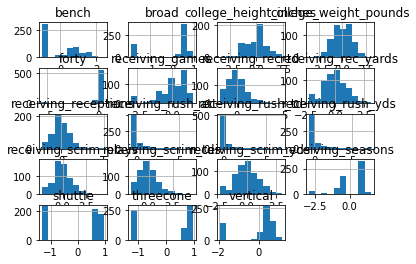

In [49]:
# histograms for some interesting measurements
X_train.hist()
pyplot.show()

In [50]:
result_df = test_df[['full_name', prediction_feature, 'position_group_rank']].copy()
print(result_df)
def result_df_viz(df, predictions, model_name):
    
    df[model_name] = predictions
    #return result_df.sort_values(by=['max_madden_pred'], ascending=False)
    return df

                   full_name  madden_cat  position_group_rank
fms_id                                                       
697               Cam Worthy          40                 27.0
1919            Geremy Davis          60                 23.0
4847           Ty Montgomery          70                 14.0
867             Chris Conley          70                 12.0
2954              Kenny Bell          60                 21.0
2239         Jamison Crowder          80                 15.0
166             Amari Cooper          80                  1.0
4928             Vince Mayle          70                 17.0
2117           Jaelen Strong          70                 11.0
1561             Devin Smith          70                  7.0
4866           Tyler Lockett          80                 10.0
2699             Josh Harper          60                 36.0
2895          Keith Mumphery          60                 37.0
2787            Justin Hardy          70                 16.0
3741    

In [51]:
# Plot feature importance
def plot_feat_import(coef, model_title):
    feature_coef = pd.Series(index=X_train.columns, data=coef)
    print('{} model picked {} out of {} features'.format(model_title, str(sum(feature_coef != 0)), str(X_train.shape[1])))
    top_bottom_10 = pd.concat([feature_coef.sort_values().head(10), feature_coef.sort_values().tail(10)])
    top_bottom_10.plot(kind='barh', title='Feature importance (Top and bottom 10) - {} model'.format(model_title))
    #from W207 project (Fleishman, Hilton, Niu)
    
# Plot predictions
def plot_it(y_train, y_valid, model_title):
    plt.scatter(y_train, train_labels, c = "blue", alpha=0.6, marker = "o", label = "Training data")
    plt.scatter(y_valid, dev_labels, c = "green", alpha=0.6, marker = "o", label = "Validation data")
    plt.title(model_title)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()
    
class_names = [40, 50, 60, 70, 80, 90]

In [52]:
#Logistic Regression:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
madden_predict = clf.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print(madden_predict)
result_df_viz(result_df, madden_predict, 'Log_Regression')


Accuracy:  0.38461538461538464
R2 : -2.26094276094276
[40 60 40 70 60 70 70 40 40 70 40 60 40 70 40 40 90 70 60 40 70 70 40 60
 70 70 70 70 40 60 60 60 60 70 70 60 40 70 40]


,full_name,madden_cat,position_group_rank,Log_Regression
fms_id,,,,
697,Cam Worthy,40,27.0,40
1919,Geremy Davis,60,23.0,60
4847,Ty Montgomery,70,14.0,40
867,Chris Conley,70,12.0,70
2954,Kenny Bell,60,21.0,60
2239,Jamison Crowder,80,15.0,70
166,Amari Cooper,80,1.0,70
4928,Vince Mayle,70,17.0,40
2117,Jaelen Strong,70,11.0,40


Lasso Model
Accuracy:  0.05128205128205128
R2 : 0.01143097643097668
MSE : 115.82051282051282
Lasso model picked 12 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso
fms_id,,,,,
697,Cam Worthy,40,27.0,40,58.0
1919,Geremy Davis,60,23.0,60,60.0
4847,Ty Montgomery,70,14.0,40,61.0
867,Chris Conley,70,12.0,70,63.0
2954,Kenny Bell,60,21.0,60,61.0
2239,Jamison Crowder,80,15.0,70,61.0
166,Amari Cooper,80,1.0,70,65.0
4928,Vince Mayle,70,17.0,40,62.0
2117,Jaelen Strong,70,11.0,40,64.0


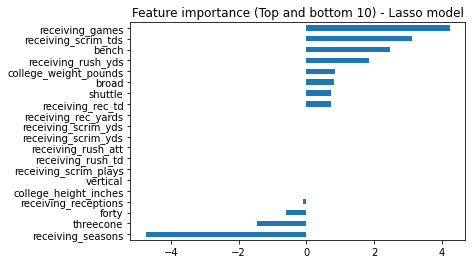

In [53]:
#Lasso:
alpha = 0.1
lasso_model = Lasso(alpha=alpha).fit(X_train, Y_train)
madden_predict = lasso_model.predict(X_validation)

madden_predict = np.around(madden_predict, decimals = 0)

print('Lasso Model')
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))

plot_feat_import(lasso_model.coef_, 'Lasso')  
#plot_it()
print('----------')
result_df_viz(result_df, madden_predict, 'Lasso')


Accuracy:  0.05128205128205128
R2 : -0.004983164983164645
MSE : 117.74358974358974
LassoCV Model
Lassocv model picked 11 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV
fms_id,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0
1919,Geremy Davis,60,23.0,60,60.0,60.0
4847,Ty Montgomery,70,14.0,40,61.0,60.0
867,Chris Conley,70,12.0,70,63.0,63.0
2954,Kenny Bell,60,21.0,60,61.0,61.0
2239,Jamison Crowder,80,15.0,70,61.0,61.0
166,Amari Cooper,80,1.0,70,65.0,64.0
4928,Vince Mayle,70,17.0,40,62.0,62.0
2117,Jaelen Strong,70,11.0,40,64.0,63.0


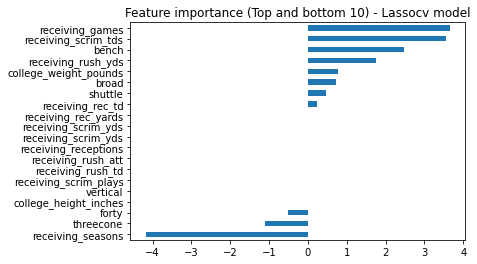

In [54]:
#Lassocv:

lasso_modelcv = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
madden_predict = lasso_modelcv.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
print('LassoCV Model')
plot_feat_import(lasso_modelcv.coef_, 'Lassocv') 
print('----------')
result_df_viz(result_df, madden_predict, 'LassoCV')


RidgeCV Model
Accuracy:  0.05128205128205128
R2 : 0.013619528619528865
MSE : 115.56410256410257
RidgeCV model picked 19 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV
fms_id,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0
867,Chris Conley,70,12.0,70,63.0,63.0,64.0
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0


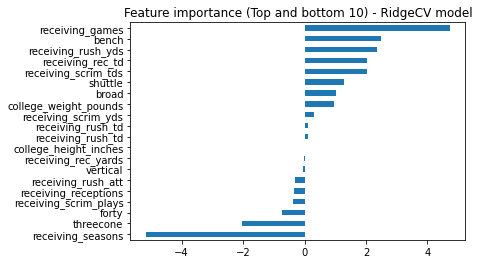

In [55]:
#RidgeCV:

ridge_model = RidgeCV(cv=5).fit(X_train, Y_train)
madden_predict = ridge_model.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)

print('RidgeCV Model')
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))

plot_feat_import(ridge_model.coef_, 'RidgeCV')
print('----------')
result_df_viz(result_df, madden_predict, 'RidgeCV')

ElasticNetCV Model
Accuracy:  0.05128205128205128
R2 : -0.002356902356902113
MSE : 117.43589743589743
ElasticNetCV model picked 14 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV
fms_id,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0


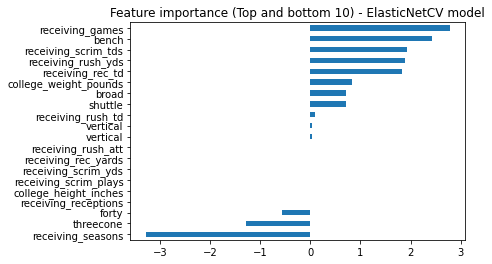

In [56]:
#ElasticNetCV:

elasticnetcv_model = ElasticNetCV(cv=5, random_state=0).fit(X_train, Y_train)
madden_predict = elasticnetcv_model.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print('ElasticNetCV Model')
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(elasticnetcv_model.coef_, 'ElasticNetCV')
result_df_viz(result_df, madden_predict, 'ElasticNetCV')

Accuracy:  0.3333333333333333
R2 : -1.1010101010101003
MSE : 246.15384615384616
Decision Tree Regressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg
fms_id,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0


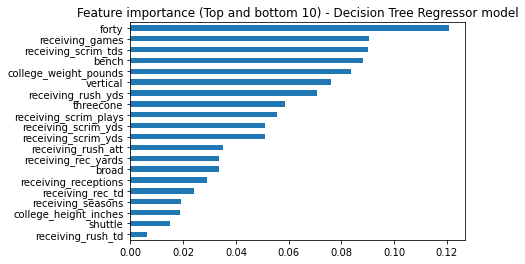

In [57]:
#Decision Tree Regressor
from sklearn import tree
decisiontreeregrssor = DecisionTreeRegressor()
decisiontreeregrssor.fit(X_train, Y_train)
madden_predict = decisiontreeregrssor.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(decisiontreeregrssor.feature_importances_, 'Decision Tree Regressor')
result_df_viz(result_df, madden_predict, 'Decision_Tree_Reg')

Accuracy:  0.5897435897435898
R2 : 0.19023569023569042
MSE : 94.87179487179488
AdaBoostRegressor model picked 19 out of 19 features
[[ 0  0  3  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  1 11  4  0  0]
 [ 0  0  1 11  0  0]
 [ 0  0  2  3  1  0]
 [ 0  0  0  1  0  0]]


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost
fms_id,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0


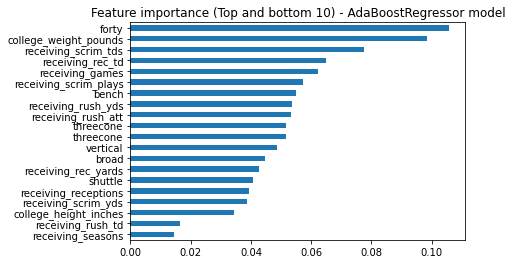

In [58]:
#Adaboost
adaboostregressor = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse'), n_estimators=100, loss='linear', learning_rate=1, random_state=1)
adaboostregressor.fit(X_train, Y_train)
madden_predict = adaboostregressor.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(adaboostregressor.feature_importances_, 'AdaBoostRegressor')
adaboost_mat = confusion_matrix(Y_validation, madden_predict, labels = class_names)
print(adaboost_mat)
result_df_viz(result_df, madden_predict, 'AdaBoost')
#plot_confusion_matrix(adaboostregressor, X_validation, Y_validation)


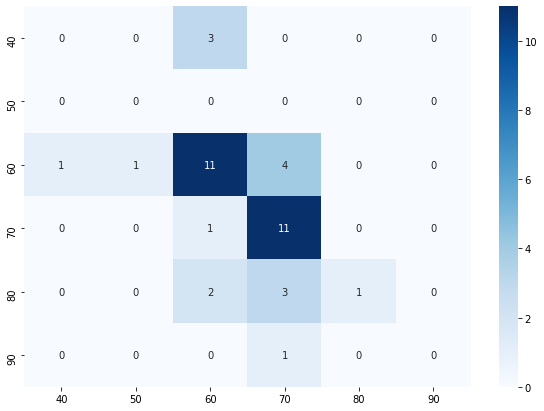

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = adaboost_mat
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

Accuracy:  0.38461538461538464
R2 : -1.4511784511784507
MSE : 287.1794871794872
Decision Tree Classifier model picked 19 out of 19 features
[[2 0 1 0 0]
 [3 8 3 2 1]
 [3 4 4 1 0]
 [2 1 2 0 1]
 [0 0 0 0 1]]


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class
fms_id,,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0,40
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0,60
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0,70
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0,60
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0,60
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0,60
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0,70
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0,40
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0,70


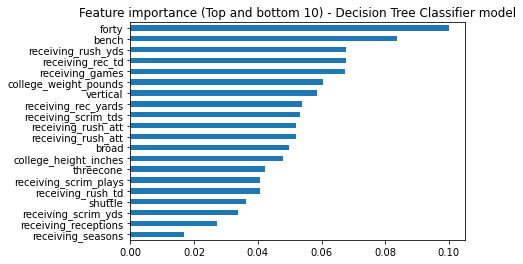

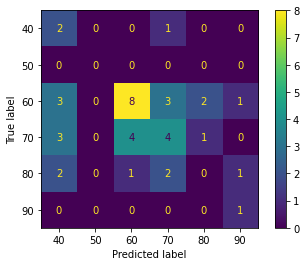

In [60]:
#Decision Tree
from sklearn import tree
decisiontree = DecisionTreeClassifier(max_depth = 100)
decisiontree.fit(X_train, Y_train)
madden_predict = decisiontree.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(decisiontree.feature_importances_, 'Decision Tree Classifier')
print(confusion_matrix(Y_validation, madden_predict))
plot_confusion_matrix(decisiontree, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'Decision_Tree_Class')

Accuracy:  0.48717948717948717
R2 : -1.3636363636363629
MSE : 276.9230769230769
Extra Tree Classifier model picked 19 out of 19 features
[[ 1  2  0  0  0]
 [ 5 10  2  0  0]
 [ 2  1  8  1  0]
 [ 3  1  2  0  0]
 [ 0  0  1  0  0]]


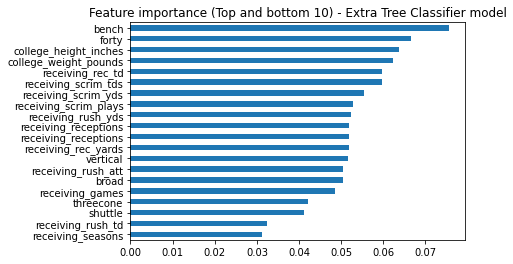

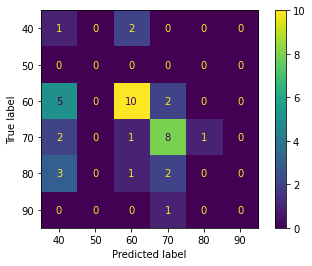

In [61]:
#Extra Tree


from sklearn import tree
extradecisiontree = ExtraTreesClassifier(max_depth = 300)
extradecisiontree.fit(X_train, Y_train)
madden_predict = extradecisiontree.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(extradecisiontree.feature_importances_, 'Extra Tree Classifier')
result_df_viz(result_df, madden_predict, 'Extra_Tree')
print(confusion_matrix(Y_validation, madden_predict))
plot_confusion_matrix(extradecisiontree, X_validation, Y_validation, labels=class_names)

Accuracy:  0.28205128205128205
R2 : -1.6919191919191912
MSE : 315.38461538461536
AdaBoostClassifier model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class
fms_id,,,,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0,40,40,40
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0,60,60,60
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0,70,70,60
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0,60,70,80
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0,60,60,50
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0,60,60,60
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0,70,40,70
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0,40,40,40
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0,70,40,70


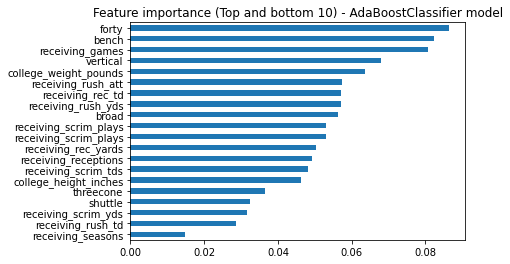

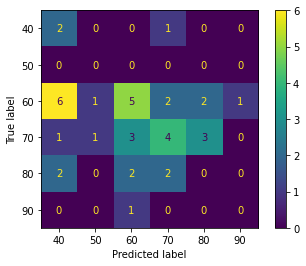

In [62]:
#Adaboost
adaboostclassifier = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
adaboostclassifier.fit(X_train, Y_train)
madden_predict = adaboostclassifier.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(adaboostclassifier.feature_importances_, 'AdaBoostClassifier')

plot_confusion_matrix(adaboostclassifier, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'AdaBoost_Class')


Accuracy:  0.38461538461538464
R2 : -1.9983164983164974
MSE : 351.28205128205127


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM
fms_id,,,,,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0,40,40,40,40
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0,60,60,60,60
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0,70,70,60,40
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0,60,70,80,60
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0,60,60,50,60
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0,60,60,60,70
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0,70,40,70,40
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0,40,40,40,40
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0,70,40,70,40


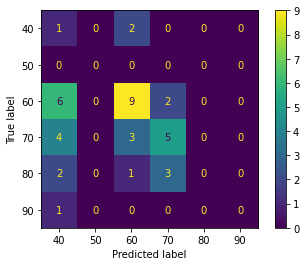

In [63]:
#SVM
svmclassifier = SVC(gamma='auto')
svmclassifier.fit(X_train, Y_train)
madden_predict = svmclassifier.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
#plot_feat_import(svmclassifier.feature_importances_, 'SVC')
plot_confusion_matrix(svmclassifier, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'SVM')

Accuracy:  0.48717948717948717
R2 : -0.5319865319865316
MSE : 179.48717948717947
Random Forest model picked 19 out of 19 features


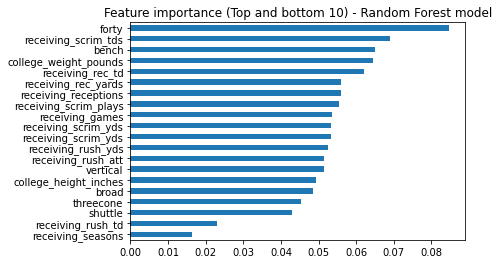

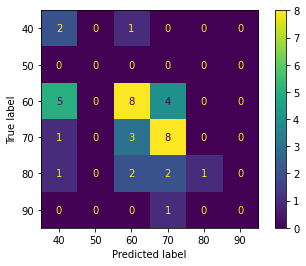

In [64]:
#RandomForest
rfclassifier = RandomForestClassifier()
rfclassifier.fit(X_train, Y_train)
madden_predict = rfclassifier.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(rfclassifier.feature_importances_, 'Random Forest')
result_df_viz(result_df, madden_predict, 'RF_Class')
plot_confusion_matrix(rfclassifier, X_validation, Y_validation, labels = class_names)

In [65]:
#PCA with Linear Regression
pca = PCA(n_components=5)
pca_x = pca.fit_transform(X_train)
pca_validation = pca.transform(X_validation)

log_pca = LogisticRegression(random_state=0).fit(pca_x, Y_train)
madden_predict = log_pca.predict(pca_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
#print(log_pca.coef_.shape)
#plot_feat_import(log_pca.coef_, 'PCA with Log Regression')
result_df_viz(result_df, madden_predict, 'Log_PCA')

Accuracy:  0.3333333333333333
R2 : -1.407407407407407
MSE : 282.05128205128204


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA
fms_id,,,,,,,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0,40,40,40,40,60,40
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0,60,60,60,60,60,60
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0,70,70,60,40,70,60
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0,60,70,80,60,60,60
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0,60,60,50,60,70,60
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0,60,60,60,70,60,70
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0,70,40,70,40,70,70
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0,40,40,40,40,40,70
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0,70,40,70,40,70,70


Accuracy:  0.05128205128205128
R2 : 0.14865319865319893
MSE : 99.74358974358974
Gradient Booster Regressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA,GB_Regressor
fms_id,,,,,,,,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0,40,40,40,40,60,40,55.0
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0,60,60,60,60,60,60,56.0
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0,70,70,60,40,70,60,50.0
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0,60,70,80,60,60,60,65.0
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0,60,60,50,60,70,60,68.0
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0,60,60,60,70,60,70,59.0
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0,70,40,70,40,70,70,79.0
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0,40,40,40,40,40,70,58.0
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0,70,40,70,40,70,70,77.0


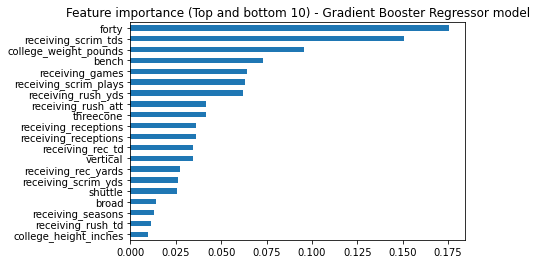

In [66]:
#Gradient Booster Regressor
import numpy as np
gradientboostingregressor = GradientBoostingRegressor(random_state=0)
gradientboostingregressor.fit(X_train, Y_train)
madden_predict = gradientboostingregressor.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(gradientboostingregressor.feature_importances_, 'Gradient Booster Regressor')
result_df_viz(result_df, madden_predict, 'GB_Regressor')

In [67]:
from scipy.stats import rankdata
print(result_df.columns[3:])
rank_df = result_df[result_df.columns[3:]]
#for col in rank_df.columns:
#    rank_df[col] = rankdata(rank_df[col].values)

Index(['Log_Regression', 'Lasso', 'LassoCV', 'RidgeCV', 'ElasticNetCV',
       'Decision_Tree_Reg', 'AdaBoost', 'Decision_Tree_Class', 'Extra_Tree',
       'AdaBoost_Class', 'SVM', 'RF_Class', 'Log_PCA', 'GB_Regressor'],
      dtype='object')


In [68]:
def rank(row):
    print()
    return row.sum()/len(row)
result_df['rank'] = rank_df.apply(rank, axis=1)
result_df

,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA,GB_Regressor,rank
fms_id,,,,,,,,,,,,,,,,,,
697,Cam Worthy,40,27.0,40,58.0,58.0,58.0,58.0,40.0,60.0,40,40,40,40,60,40,55.0,49.071429
1919,Geremy Davis,60,23.0,60,60.0,60.0,59.0,59.0,40.0,60.0,60,60,60,60,60,60,56.0,58.142857
4847,Ty Montgomery,70,14.0,40,61.0,60.0,61.0,60.0,70.0,70.0,70,70,60,40,70,60,50.0,60.142857
867,Chris Conley,70,12.0,70,63.0,63.0,64.0,63.0,70.0,70.0,60,70,80,60,60,60,65.0,65.571429
2954,Kenny Bell,60,21.0,60,61.0,61.0,62.0,60.0,60.0,70.0,60,60,50,60,70,60,68.0,61.571429
2239,Jamison Crowder,80,15.0,70,61.0,61.0,61.0,61.0,40.0,60.0,60,60,60,70,60,70,59.0,60.928571
166,Amari Cooper,80,1.0,70,65.0,64.0,65.0,64.0,90.0,80.0,70,40,70,40,70,70,79.0,66.928571
4928,Vince Mayle,70,17.0,40,62.0,62.0,62.0,62.0,60.0,60.0,40,40,40,40,40,70,58.0,52.571429
2117,Jaelen Strong,70,11.0,40,64.0,63.0,64.0,63.0,80.0,70.0,70,40,70,40,70,70,77.0,62.928571


In [69]:
#def rank(row):
#    print()
#    return row.sum()/len(row)
#result_df['rank'] = rankdata(rank_df.apply(rank, axis=1))

ordered_df = result_df[['full_name', 'AdaBoost', prediction_feature, 'position_group_rank']].sort_values(by=['AdaBoost'], ascending=False)
ordered_df

,full_name,AdaBoost,madden_cat,position_group_rank
fms_id,,,,
166,Amari Cooper,80.0,80,1.0
4462,Stefon Diggs,70.0,90,19.0
4286,Sammie Coates,70.0,70,13.0
1645,Dorial Green-Beckham,70.0,70,8.0
1288,Darren Waller,70.0,60,24.0
576,Breshad Perriman,70.0,70,5.0
3035,Kevin White,70.0,70,2.0
1422,DeVante Parker,70.0,80,3.0
1397,DeAndre Smelter,70.0,60,30.0


In [70]:
ordered_df.to_csv('rank_of_picks.csv')

eclf = VotingClassifier(estimators=[('svc', svmclassifier), ('extratrees', extradecisiontree), ('rf', rfclassifier), ('logpca', log_pca)],voting='hard')


for clf, label in zip([svmclassifier, extradecisiontree, rfclassifier, log_pca, eclf], ['SVC', 'Extra Trees', 'Random Forest', 'Log_pca', 'Ensemble']): 
    scores = cross_val_score(clf, value_data, label_data, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
#



In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#models.append(('LASSO', Lasso(alpha=0.1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier(n_estimators=200)))
models.append(('RFC', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('ETC', ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, value_data, label_data, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


In [ ]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()